<a href="https://colab.research.google.com/github/Adityan1512/Computational-Methods-CW/blob/main/w1977985_AI_ML_CourseWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AI Assignment - JP Morgan Case Study

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
#Importing Libraries

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, roc_curve, classification_report
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

In [7]:
pd.options.mode.chained_assignment = None

JP Morgan Historical Data

In [11]:
jpmcdata = yf.download('JPM', start='2014-01-01', end='2023-12-31')

jpmcdata.head(5)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,58.310001,58.500000,57.970001,58.209999,44.047367,15627600
2014-01-03,58.290001,58.950001,58.209999,58.660000,44.387886,14214100
2014-01-06,59.160000,59.470001,58.830002,59.000000,44.645172,17550700
2014-01-07,59.290001,59.430000,58.110001,58.320000,44.130604,17851200
2014-01-08,58.540001,58.910000,58.299999,58.869999,44.546795,14687400


Data cleansing & wrangling

In [12]:
jpmcdata = jpmcdata.dropna()
jpmcdata = jpmcdata[['Volume','Open','High','Low','Close']]
jpmcdata.head(10)

,Volume,Open,High,Low,Close
Date,,,,,
2014-01-02,15627600,58.310001,58.500000,57.970001,58.209999
2014-01-03,14214100,58.290001,58.950001,58.209999,58.660000
2014-01-06,17550700,59.160000,59.470001,58.830002,59.000000
2014-01-07,17851200,59.290001,59.430000,58.110001,58.320000
2014-01-08,14687400,58.540001,58.910000,58.299999,58.869999
2014-01-09,13242500,58.980000,59.000000,58.330002,58.759998
2014-01-10,12694900,58.669998,58.759998,58.180000,58.490002
2014-01-13,20711600,58.509998,58.669998,57.529999,57.700001
2014-01-14,30272400,58.299999,58.580002,57.560001,57.740002


Extrapolating historical data

In [14]:
jpmcdata['H-L'] = jpmcdata['High'] - jpmcdata['Low']
jpmcdata['O-C'] = jpmcdata['Close'] - jpmcdata['Open']

jpmcdata['3day_moving_avg'] = jpmcdata['Close'].shift(1).rolling(window = 3).mean()
jpmcdata['10day_moving_avg'] = jpmcdata['Close'].shift(1).rolling(window = 10).mean()
jpmcdata['30day_moving_avg'] = jpmcdata['Close'].shift(1).rolling(window = 30).mean()

jpmcdata['std_dev'] = jpmcdata['Close'].rolling(5).std()

jpmcdata['Price_Rise'] = np.where(jpmcdata['Close'].shift(-1) > jpmcdata['Close'], 1, 0)

jpmcdata = jpmcdata.dropna()

jpmcdata.head(10)


,Volume,Open,High,Low,Close,H-L,O-C,3day_moving_avg,10day_moving_avg,30day_moving_avg,std_dev,Price_Rise
Date,,,,,,,,,,,,
2014-02-14,13067300,57.889999,58.230000,57.750000,58.150002,0.480000,0.260002,57.660000,56.265,57.155667,0.561008,1
2014-02-18,14983800,58.020000,58.650002,57.900002,58.490002,0.750000,0.470001,57.900000,56.544,57.153667,0.444388,0
2014-02-19,18669900,58.360001,58.540001,57.220001,57.259998,1.320000,-1.100002,58.223334,56.962,57.148000,0.495228,1
2014-02-20,12457000,57.529999,57.970001,57.270000,57.580002,0.700001,0.050003,57.966667,57.193,57.090000,0.484635,1
2014-02-21,16790100,57.590000,57.840000,57.369999,57.610001,0.470001,0.020000,57.776667,57.430,57.065334,0.493225,1
2014-02-24,16151400,57.619999,58.230000,57.580002,58.029999,0.649998,0.410000,57.483334,57.543,57.023334,0.475637,0
2014-02-25,17991800,57.900002,57.980000,56.919998,57.029999,1.060001,-0.870003,57.740000,57.684,56.999000,0.380092,0
2014-02-26,23661700,57.369999,57.380001,56.220001,56.750000,1.160000,-0.619999,57.556666,57.713,56.950334,0.508134,0
2014-02-27,16277500,56.779999,56.889999,56.139999,56.689999,0.750000,-0.090000,57.269999,57.645,56.918667,0.580104,1


Exploratory Data Analysis

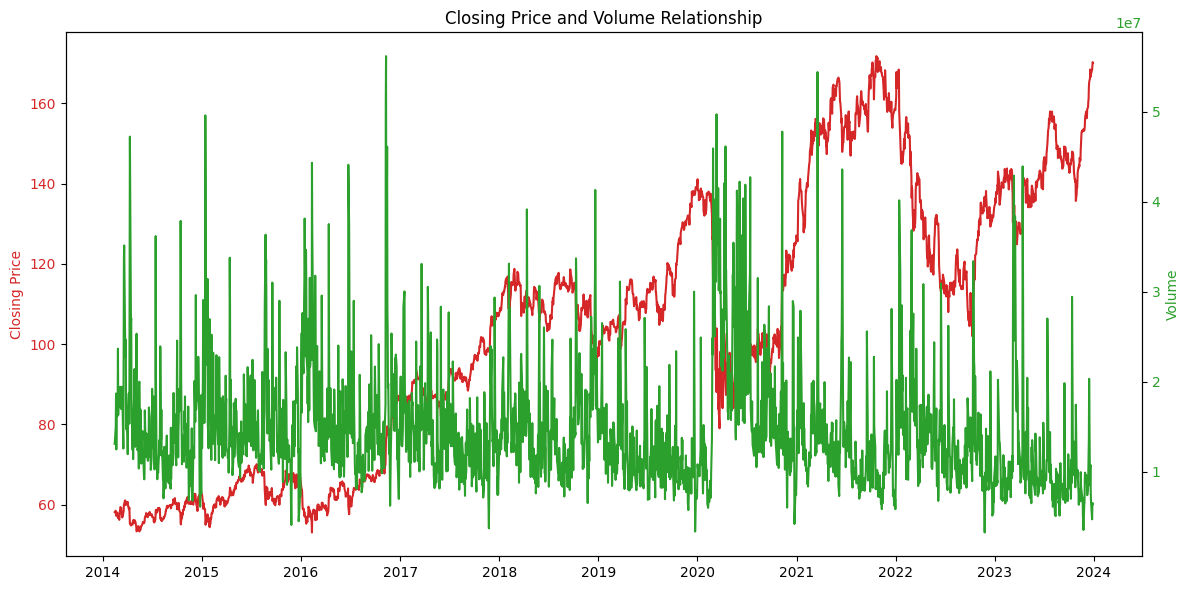

In [21]:
fig, ax1 = plt.subplots(figsize=(12,6))


color = 'tab:red'
ax1.set_ylabel('Closing Price', color=color)
ax1.plot(jpmcdata['Close'], label='Close', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Volume', color=color)
ax2.plot(jpmcdata['Volume'], label='Volume', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Closing Price and Volume Relationship')
fig.tight_layout()
plt.show()

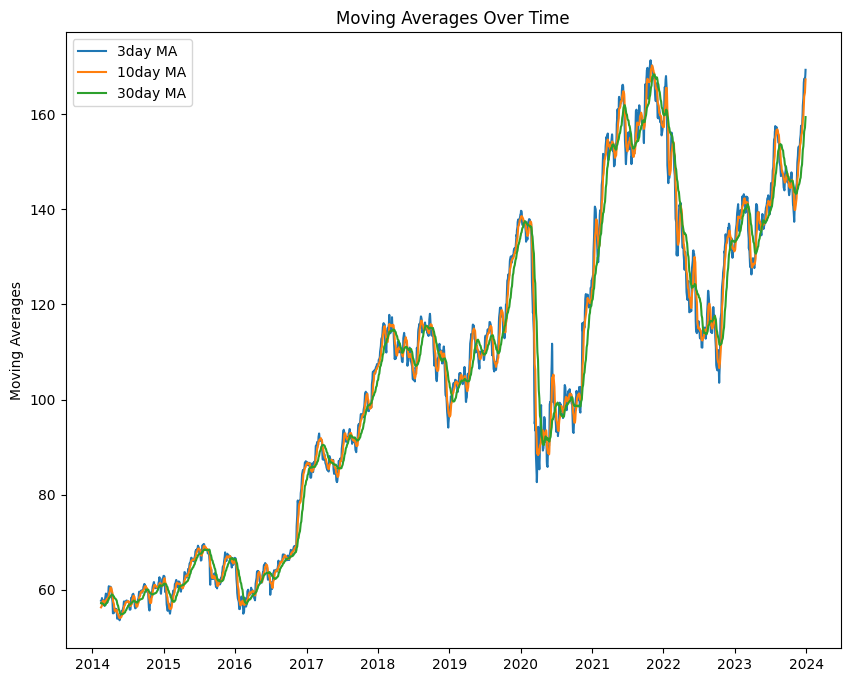

In [23]:
plt.figure(figsize=(10,8 ))

plt.plot(jpmcdata['3day_moving_avg'], label='3day MA')
plt.plot(jpmcdata['10day_moving_avg'], label='10day MA')
plt.plot(jpmcdata['30day_moving_avg'], label='30day MA')

plt.title('Moving Averages Over Time')
plt.ylabel('Moving Averages')
plt.legend()
plt.show()

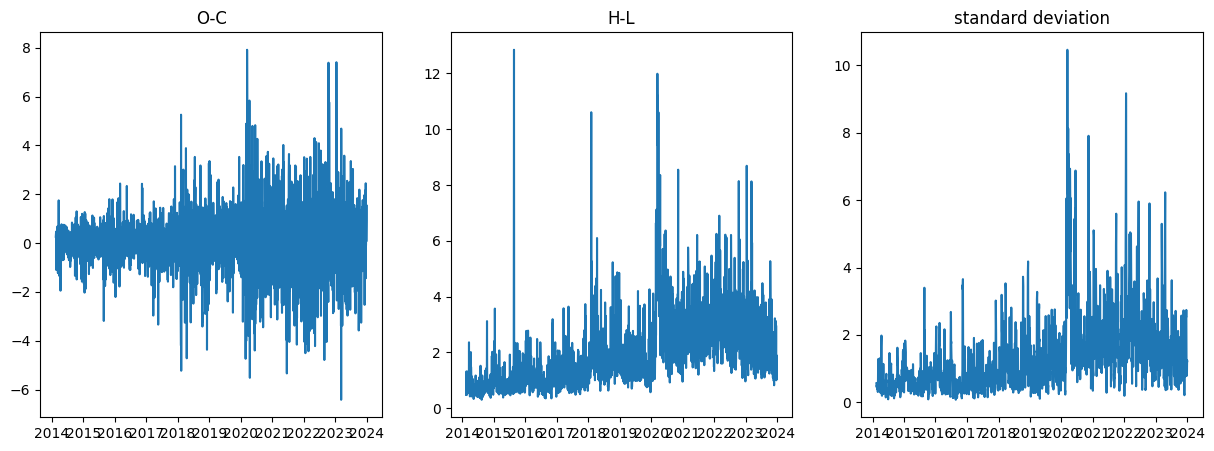

In [25]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))

axes[0].plot(jpmcdata['O-C'])
axes[0].set_title('O-C')
axes[1].plot(jpmcdata['H-L'])
axes[1].set_title('H-L')
axes[2].plot(jpmcdata['std_dev'])
axes[2].set_title('standard deviation')

plt.show()


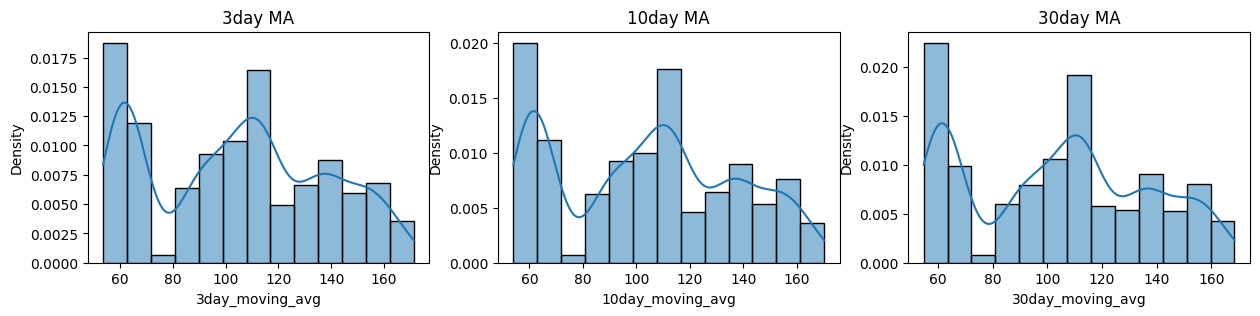

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))

sns.histplot(data=jpmcdata, x= "3day_moving_avg", kde=True, stat='density', ax=axes[0])
axes[0].set_title('3day MA')

sns.histplot(data=jpmcdata, x= "10day_moving_avg", kde=True, stat='density', ax=axes[1])
axes[1].set_title('10day MA')

sns.histplot(data=jpmcdata, x= "30day_moving_avg", kde=True, stat='density', ax=axes[2])
axes[2].set_title('30day MA')

plt.show()

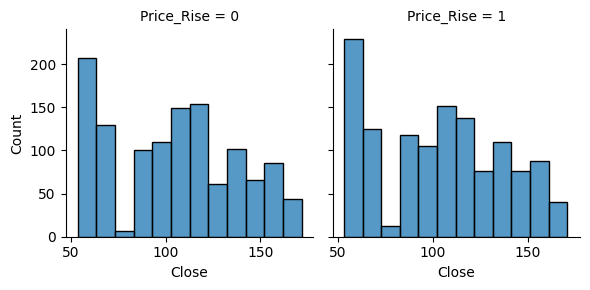

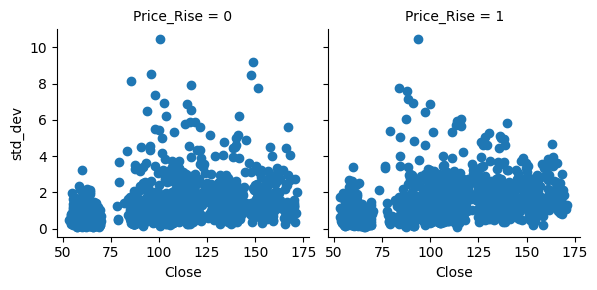

In [27]:
chart = sns.FacetGrid(jpmcdata, col='Price_Rise')
chart.map(sns.histplot, 'Close')

chart = sns.FacetGrid(jpmcdata, col='Price_Rise')
chart.map(plt.scatter, 'Close', 'std_dev')

In [28]:
jpmcdata.describe()

,Volume,Open,High,Low,Close,H-L,O-C,3day_moving_avg,10day_moving_avg,30day_moving_avg,std_dev,Price_Rise
count,2.486000e+03,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000,2486.000000
mean,1.455782e+07,104.360724,105.330998,103.394183,104.371392,1.936814,0.010668,104.281054,104.123911,103.705365,1.356535,0.510861
std,6.517369e+06,33.297639,33.610405,32.999215,33.303641,1.315617,1.309183,33.256717,33.162590,32.947617,1.133901,0.499983
min,3.220500e+06,53.080002,53.509998,50.070000,53.070000,0.299999,-6.419998,53.550001,54.004000,54.807000,0.071623,0.000000
25%,1.032355e+07,67.645000,68.017500,67.100002,67.602499,1.000000,-0.590000,67.465831,67.221250,66.991917,0.607510,0.000000
50%,1.301890e+07,106.305000,107.299999,105.029999,106.139999,1.610001,0.049995,106.213333,106.268501,107.090834,1.060412,1.000000
75%,1.680732e+07,131.815006,132.935001,130.327503,131.580002,2.457497,0.630001,131.392501,131.892752,131.688416,1.742429,1.000000
max,5.619230e+07,172.710007,172.960007,170.539993,171.779999,12.849998,7.920006,171.373332,170.281000,168.400667,10.466817,1.000000


In [29]:
jpmcdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2486 entries, 2014-02-14 to 2023-12-29
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Volume            2486 non-null   int64  
 1   Open              2486 non-null   float64
 2   High              2486 non-null   float64
 3   Low               2486 non-null   float64
 4   Close             2486 non-null   float64
 5   H-L               2486 non-null   float64
 6   O-C               2486 non-null   float64
 7   3day_moving_avg   2486 non-null   float64
 8   10day_moving_avg  2486 non-null   float64
 9   30day_moving_avg  2486 non-null   float64
 10  std_dev           2486 non-null   float64
 11  Price_Rise        2486 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 252.5 KB


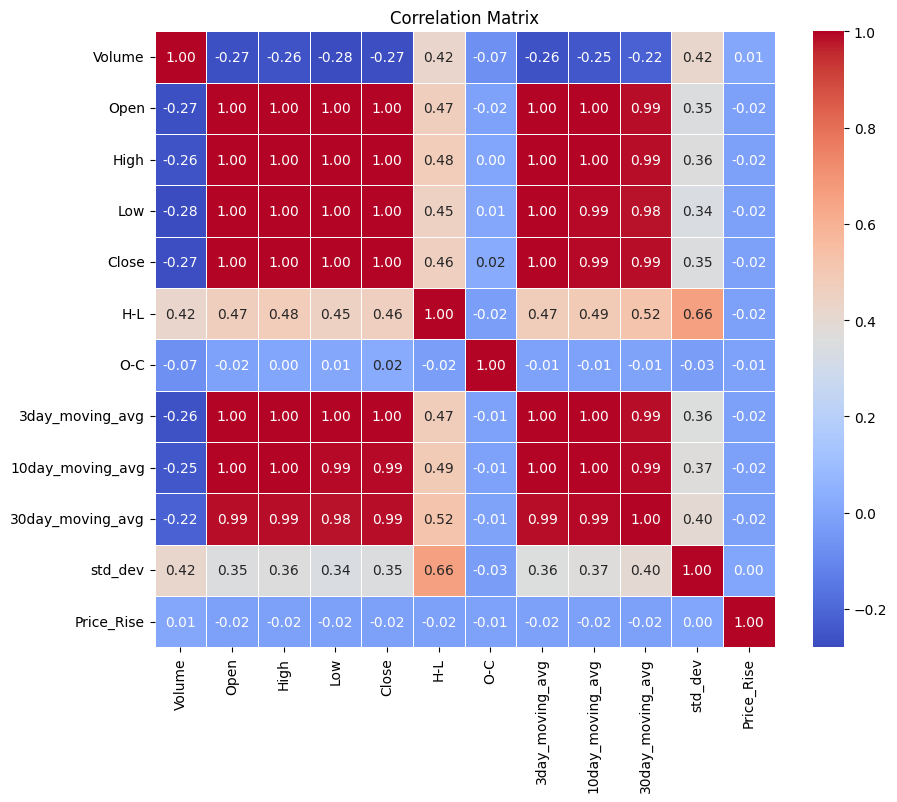

In [30]:
corr_matrix = jpmcdata.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Clasification - Logistic Regression

In [31]:
#Setting X & Y datasets i.e splitting data & result

X = jpmcdata.iloc[:, 5:-1]
Y = jpmcdata.iloc[:, -1]

In [33]:
X.head(5)

,H-L,O-C,3day_moving_avg,10day_moving_avg,30day_moving_avg,std_dev
Date,,,,,,
2014-02-14,0.480000,0.260002,57.660000,56.265,57.155667,0.561008
2014-02-18,0.750000,0.470001,57.900000,56.544,57.153667,0.444388
2014-02-19,1.320000,-1.100002,58.223334,56.962,57.148000,0.495228
2014-02-20,0.700001,0.050003,57.966667,57.193,57.090000,0.484635
2014-02-21,0.470001,0.020000,57.776667,57.430,57.065334,0.493225


In [32]:
#train test split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, shuffle=False)

In [35]:
x_test.head(5)

,H-L,O-C,3day_moving_avg,10day_moving_avg,30day_moving_avg,std_dev
Date,,,,,,
2023-01-04,2.109985,0.389999,134.146667,132.149002,133.257334,1.547668
2023-01-05,2.010010,-0.309998,135.200002,132.781003,133.342001,1.212634
2023-01-06,3.889999,1.809998,135.616669,133.247003,133.418668,1.455032
2023-01-09,2.000000,-1.230011,136.556671,133.825003,133.515335,1.229703
2023-01-10,1.410004,0.810013,136.886668,134.496002,133.545002,1.285056


In [36]:
#Ensuring all features/variables are in a comparable scales

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [37]:
#Defining Logistic Regression Model

modellr = LogisticRegression(random_state=101)

#training the model
modellr.fit(x_train, y_train)

#predicting the outcomes on out test set
y_pred = modellr.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.93      0.60       111
           1       0.53      0.07      0.12       138

    accuracy                           0.45       249
   macro avg       0.49      0.50      0.36       249
weighted avg       0.49      0.45      0.33       249



Extra Tress Model

In [38]:
#model definition
modelet = ExtraTreesClassifier(random_state=101)

#training the model
modelet.fit(x_train, y_train)

#predicting outputs using the model
y_pred = modelet.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.44      0.51      0.47       111
           1       0.54      0.46      0.50       138

    accuracy                           0.49       249
   macro avg       0.49      0.49      0.49       249
weighted avg       0.49      0.49      0.49       249



Cross Validation for logistic regression

In [40]:
accuracy_scores = cross_val_score(modellr, X, Y, cv=5, scoring=make_scorer(accuracy_score))

print("Mean Accuracy: ", accuracy_scores.mean())
print("Standard Deviation: ", accuracy_scores.std())

Mean Accuracy:  0.4967758357373155
Standard Deviation:  0.015481638541839269


Cross Validation for Extra Trees

In [41]:
accuracy_scores = cross_val_score(modelet, X, Y, cv=5, scoring=make_scorer(accuracy_score))

print("Mean Accuracy: ", accuracy_scores.mean())
print("Standard Deviation: ", accuracy_scores.std())

Mean Accuracy:  0.5108587266571315
Standard Deviation:  0.008683050617872196


Extra Tress Confusion Matrix

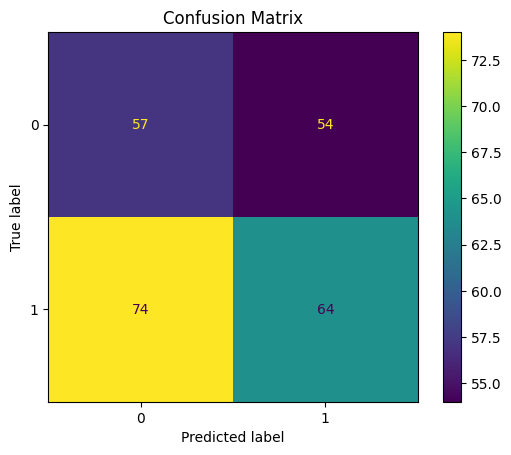

In [42]:
conf_matrix = confusion_matrix(y_test, y_pred)

matrix = ConfusionMatrixDisplay.from_estimator(modelet, x_test, y_test)
plt.title('Confusion Matrix')
plt.show(matrix)
plt.show()

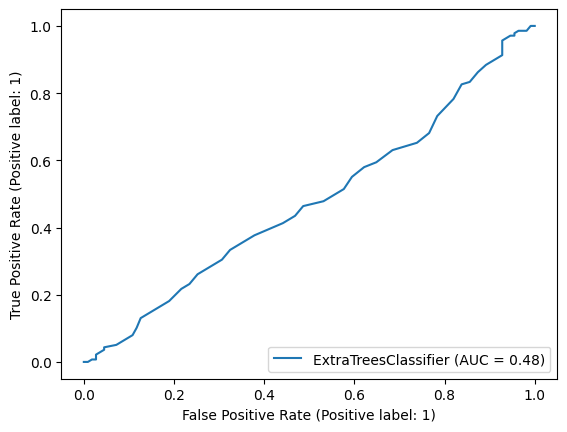

In [43]:
#ROC curve

log_disp = RocCurveDisplay.from_estimator(modelet, x_test, y_test)

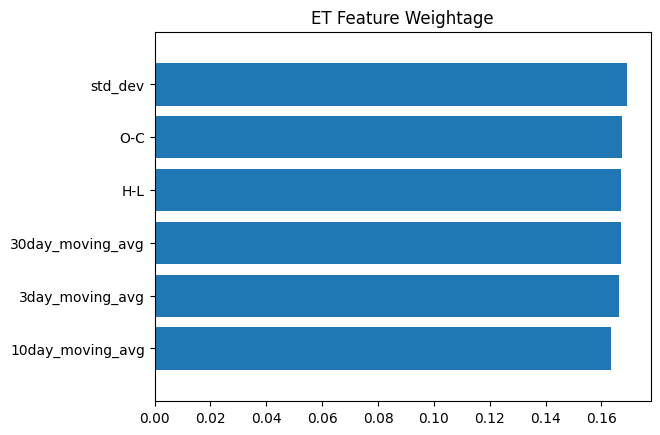

In [45]:
#weightage of features/variables

feature_name = X.columns
importance = modelet.feature_importances_
indices = np.argsort(importance)
range1 = range(len(importance[indices]))
plt.figure()
plt.title("ET Feature Weightage")
plt.barh(range1, importance[indices])
plt.yticks(range1, feature_name[indices])
plt.ylim([-1, len(range1)])
plt.show()

Market & return Strategy

In [46]:
jpmcdata['y_pred'] = np.NaN
jpmcdata.iloc[(len(jpmcdata) - len(y_pred)):, -1] = y_pred
trade_jpmcdata = jpmcdata.dropna()
trade_jpmcdata.head(5)

,Volume,Open,High,Low,Close,H-L,O-C,3day_moving_avg,10day_moving_avg,30day_moving_avg,std_dev,Price_Rise,y_pred
Date,,,,,,,,,,,,,
2023-01-04,11687600,135.990005,137.679993,135.570007,136.380005,2.109985,0.389999,134.146667,132.149002,133.257334,1.547668,0,1.0
2023-01-05,8381300,135.660004,135.710007,133.699997,135.350006,2.010010,-0.309998,135.200002,132.781003,133.342001,1.212634,1,0.0
2023-01-06,10029100,136.130005,138.380005,134.490005,137.940002,3.889999,1.809998,135.616669,133.247003,133.418668,1.455032,0,0.0
2023-01-09,8482300,138.600006,138.880005,136.880005,137.369995,2.000000,-1.230011,136.556671,133.825003,133.515335,1.229703,1,1.0
2023-01-10,9048700,137.789993,138.720001,137.309998,138.600006,1.410004,0.810013,136.886668,134.496002,133.545002,1.285056,1,1.0


In [48]:
trade_jpmcdata['Tomorrows_return'] = 0
trade_jpmcdata['Tomorrows_return'] = np.log(trade_jpmcdata['Close']/trade_jpmcdata['Close'].shift(1))
trade_jpmcdata['Tomorrows_return'] = trade_jpmcdata['Tomorrows_return'].shift(-1)
trade_jpmcdata.head()

,Volume,Open,High,Low,Close,H-L,O-C,3day_moving_avg,10day_moving_avg,30day_moving_avg,std_dev,Price_Rise,y_pred,Tomorrows_return
Date,,,,,,,,,,,,,,
2023-01-04,11687600,135.990005,137.679993,135.570007,136.380005,2.109985,0.389999,134.146667,132.149002,133.257334,1.547668,0,1.0,-0.007581
2023-01-05,8381300,135.660004,135.710007,133.699997,135.350006,2.010010,-0.309998,135.200002,132.781003,133.342001,1.212634,1,0.0,0.018955
2023-01-06,10029100,136.130005,138.380005,134.490005,137.940002,3.889999,1.809998,135.616669,133.247003,133.418668,1.455032,0,0.0,-0.004141
2023-01-09,8482300,138.600006,138.880005,136.880005,137.369995,2.000000,-1.230011,136.556671,133.825003,133.515335,1.229703,1,1.0,0.008914
2023-01-10,9048700,137.789993,138.720001,137.309998,138.600006,1.410004,0.810013,136.886668,134.496002,133.545002,1.285056,1,1.0,0.007404


Strategy Return Based y_pred

In [49]:
trade_jpmcdata['Strategy Returns'] = 0
trade_jpmcdata['Strategy Returns'] = np.where(trade_jpmcdata['y_pred'] == True, trade_jpmcdata['Tomorrows_return'], - trade_jpmcdata['Tomorrows_return'])

trade_jpmcdata.head()

,Volume,Open,High,Low,Close,H-L,O-C,3day_moving_avg,10day_moving_avg,30day_moving_avg,std_dev,Price_Rise,y_pred,Tomorrows_return,Strategy Returns
Date,,,,,,,,,,,,,,,
2023-01-04,11687600,135.990005,137.679993,135.570007,136.380005,2.109985,0.389999,134.146667,132.149002,133.257334,1.547668,0,1.0,-0.007581,-0.007581
2023-01-05,8381300,135.660004,135.710007,133.699997,135.350006,2.010010,-0.309998,135.200002,132.781003,133.342001,1.212634,1,0.0,0.018955,-0.018955
2023-01-06,10029100,136.130005,138.380005,134.490005,137.940002,3.889999,1.809998,135.616669,133.247003,133.418668,1.455032,0,0.0,-0.004141,0.004141
2023-01-09,8482300,138.600006,138.880005,136.880005,137.369995,2.000000,-1.230011,136.556671,133.825003,133.515335,1.229703,1,1.0,0.008914,0.008914
2023-01-10,9048700,137.789993,138.720001,137.309998,138.600006,1.410004,0.810013,136.886668,134.496002,133.545002,1.285056,1,1.0,0.007404,0.007404


Cumulative Market Strategy

In [51]:
trade_jpmcdata['Cumulative Market Returns'] = np.cumsum(trade_jpmcdata['Tomorrows_return'])
trade_jpmcdata['Cumulative Strategy Returns'] = np.cumsum(trade_jpmcdata['Strategy Returns'])

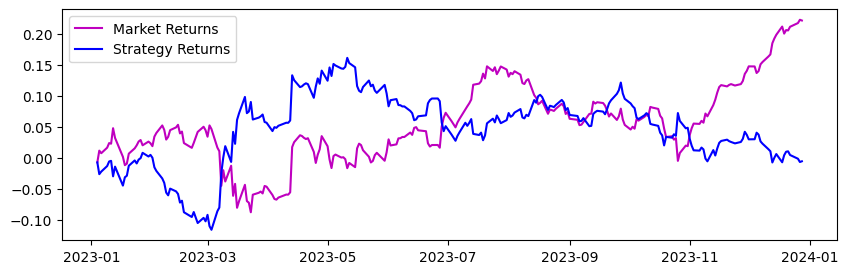

In [60]:
plt.figure(figsize=(10,3))
plt.plot(trade_jpmcdata['Cumulative Market Returns'], color='m', label='Market Returns')
plt.plot(trade_jpmcdata['Cumulative Strategy Returns'], color='b', label='Strategy Returns')
plt.legend()
plt.show()